In [44]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import sin, cos, arccos, pi, round

from sklearn.impute import KNNImputer

from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 1° Leitura e tratamento inicial dos dados

Lendo a CSV e removendo todos os dados com valores de Tp_est iguais a zero. Além disso, foi realizado o tratamento inicial e construção das 3 bases de dados usados no algoritmo

Resultados:
- Base de dados raw para treinamento (*df_raw_train*)
- Base de dados raw para validação (*df_raw_validation*)
- Base de dados raw para teste (*df_raw_test*)

In [53]:
df_raw_data = pd.read_csv('/content/drive/MyDrive/BCC - UFPR/Semestres /9 - 2023-2/Aprendizado de Maquina/Lab2/Dados_Radar_Estacao_Completo_2018_2022.csv')
df_raw_data.drop(df_raw_data[df_raw_data['Tp_est'] == 0.0].index, inplace=True);

Remoção de colunas da base geral (2018 a 2022). A colunas removidas foram:
- Unnamed: 0 pois é a coluna de ids
- latitude e longitude pois possuem a mesma informação que as colunas lat e lon;
- distancia: Não agrega valor ao modelo.


In [54]:
df_raw_data.drop(['Unnamed: 0', 'latitude', 'longitude', 'distancia'], axis=1, inplace=True)

Separando o raw data entre treinamento e teste. Anos de 2018 a 2021 para treinamento e 2022 para teste.


In [55]:
raw_train_test_group = df_raw_data.groupby(df_raw_data['time'].str.contains('2022'))

df_raw_train = raw_train_test_group.get_group(False).copy()
df_raw_test = raw_train_test_group.get_group(True).copy()

Separando os dados de treinamento, selecionando uma porção dos dados para validação

In [56]:
dates = ['2018-01', '2018-02']

raw_train_validation_group = df_raw_train.groupby(df_raw_train['time'].str.contains('|'.join(dates)))
df_raw_train = raw_train_validation_group.get_group(False).copy()
df_raw_validation = raw_train_validation_group.get_group(True).copy()


Remoção das colunas elevation e sweep pois não possuiam valor agregado na base

Para verificar que as colunas elevation e sweep não possuiam valor agregado, foi utilizado a função describe do pandas. Com esta função, foi possível verificar que ambas possuiam média, minimo e maximo identicos, além de um desvio padrão igual a 0, ou seja, todas as linhas possuiam o mesmo valor.

In [57]:
print(df_raw_train.describe()['elevation'], end="\n\n")
print(df_raw_train.describe()['sweep'])

df_raw_train.drop(['elevation', 'sweep'], axis=1, inplace=True)
df_raw_validation.drop(['elevation', 'sweep'], axis=1, inplace=True)
df_raw_test.drop(['elevation', 'sweep'], axis=1, inplace=True)

count    83083.0
mean         0.5
std          0.0
min          0.5
25%          0.5
50%          0.5
75%          0.5
max          0.5
Name: elevation, dtype: float64

count    83083.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: sweep, dtype: float64


### 2° Separação da base de treinamento e criaçao do *input_values*
Resultados:
- Dicionario *dict_train* contendo a base de treinamento separado por estação. Nesta etapa, a base foi transformada em um np.array, tendo os campos *Est, Time, x, y, z, lat, lon e alt* removidos
- Lista *input_values* uma lista ordenanda por tp_est contendo todas as linhas da base de treinamento que possuiam todos os dados preenchidos

OBS: Como foi decidido separar a base por estações, os valores de *x, y, z, lat, lon e alt* não são mais necessários, e por este motivo foram removidos da base

In [88]:
dict_train = {}

df_train_grouped = df_raw_train.groupby(['Est'])
for est in df_train_grouped.groups.keys():
    group = df_train_grouped.get_group(est).copy()
    dict_train[est] = group.drop(['Est', 'time', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1).values.tolist()

Construção da lista *input_values*

In [89]:
df_train_no_na = df_raw_train.dropna()

input_values = []
columns = list(df_train_no_na.head())
for row in df_train_no_na.iterrows():
    row_info = {}
    for col in columns:
        row_info[col] = row[1][col]

    input_values.append(row_info)

input_values = sorted(input_values, key=lambda d: d["Tp_est"])

### 3° KNN Imputation na base de treinamento

Realização do KNN imputation para cada estação em especifico

Resultados:
- Tratamento do dict_train para cada estação, preenchendo todos os dados NaN da base


In [90]:
imputer = KNNImputer(n_neighbors=2)

for est in dict_train:
    dict_train[est] = imputer.fit_transform(dict_train[est])

### 4° Removendo outliers

Verificação dos outliers e remoção dele para cada estação

Resultados:
- Remoção dos dados com tp_est maiores que 12.4, pois representavam uma parte infima da base de dados


In [ ]:
est_data = {}
for est in dict_train:
    data = { '0 - 2.4': 0, '2.5 - 7.4': 0, '7.5 - 12.4': 0, '12.5 - 17.4': 0, '17.5 - 22.4': 0, '22.5 - 27.4': 0, '27.5 - 32.4': 0,  '32.4 - 37.5': 0}
    for row in dict_train[est]:
        if float(row[-1]) < 2.4:
            data['0 - 2.4'] += 1
        elif float(row[-1]) < 7.4:
            data['2.5 - 7.4'] += 1
        elif float(row[-1]) < 12.4:
            data['7.5 - 12.4'] += 1
        elif float(row[-1]) < 17.4:
            data['12.5 - 17.4'] += 1
        elif float(row[-1]) < 22.4:
            data['17.5 - 22.4'] += 1
        elif float(row[-1]) < 27.4:
            data['22.5 - 27.4'] += 1
        elif float(row[-1]) < 32.4:
            data['27.5 - 32.4'] += 1
        else:
            data['32.4 - 37.5'] += 1
    est_data[est] = data

est_data

In [129]:
new_dict_train = {}
for est in dict_train:
    indexes = []
    for index, row in enumerate(dict_train[est]):
        if row[-1] >= 12.4:
            indexes.append(index)
    temp = np.delete(dict_train[est], indexes, 0)
    new_dict_train[est] = temp

dict_train = new_dict_train

### 4° Preparação da base de validação
Realização da imputaçao de dados na base de validação

Resultados:
- Base de validação com todas as linhas com valores preenchidos (*df_validation*)

In [94]:
df_validation = df_raw_validation.copy()

Realizando o input na base de dados de validação

In [95]:
def get_fields_to_input(row, columns):
    fields = []
    for col in columns:
        if str(row[col]) == 'nan':
            fields.append(col)
    return fields

def get_data(tp_est, input_values):
    data = None
    min_distance = math.inf
    for value in input_values:
        distance = abs(tp_est - value["Tp_est"])
        if distance < min_distance:
            min_distance = distance
            data = value

    return data

columns = list(df_validation.head())
for row in df_validation.iterrows():

    fields_to_input = get_fields_to_input(row[1], columns)
    if len(fields_to_input) > 0:
        input_data = get_data(row[1]["Tp_est"], input_values)
        for field in fields_to_input:
            if str(row[1][field]) == 'nan':
                df_validation.loc[row[0], field] = input_data[col]

### 5° Validaçao dos modelos de regressão

Validação dos 4 modelos de regressão utilizados:
- Linear Regression
- Tree Regresion
- SVR
- KNN

Com os resultados obtidos, uma nova clusterização da base de treinamento foi montada

Resultados:
- Validação dos modelos para construção dos clusters finais de dados para o treinamento dos modelos finais


In [96]:
df_validation_for_train = df_validation.drop(['time','Est', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1)

Realizando o treinamento dos modelos e armazenando os valores das predições para calcular os erros e fazer comparações

In [102]:
def get_model(model):
    match model:
        case 'knn':
            return neighbors.KNeighborsRegressor(n_neighbors=100)
        case 'svr':
            return svm.SVR()
        case 'linear_regression':
            return linear_model.LinearRegression()
        case 'tree_regression':
            return tree.DecisionTreeRegressor()

models = ['knn', 'svr', 'linear_regression', 'tree_regression']
est_preds = {}

validate_list = np.array(df_validation_for_train.values.tolist())
x_validate = validate_list[:, :-1]
y_validate = validate_list[:, -1]

for est in dict_train:
    train_list = dict_train[est]
    x_train = train_list[:, :-1]
    y_train = train_list[:, -1]

    preds = {}
    for model_type in models:
        model = get_model(model_type)
        model.fit(x_train, y_train)

        pred = model.predict(x_validate)
        preds[model_type] = pred

    est_preds[est] = preds

Construção de um dicionário armazenando os erros de predição para cada estação

In [103]:
errors = {}
for est in est_preds:
    est_errors = {}
    for model in est_preds[est]:
        mse = mean_squared_error(y_validate, est_preds[est][model])
        mae = mean_absolute_error(y_validate, est_preds[est][model])
        est_errors[model] = { 'mse': mse, 'mae': mae }
    errors[est] = est_errors

Construindo uma tabela de comparação para tomar decisões sobre os resultados obtidos

In [ ]:
df_comparison = pd.DataFrame(columns=['Estação', 'Melhor Modelo MSE', 'MSE', 'Melhor Modelo MAE', 'MAE'])

for est in errors:
    min_mse = None
    min_mse_value = math.inf
    min_mae = None
    min_mae_value = math.inf

    for model in errors[est]:
        if errors[est][model]['mse'] < min_mse_value:
            min_mse = model
            min_mse_value = errors[est][model]['mse']
        if errors[est][model]['mae'] < min_mae_value:
            min_mae = model
            min_mae_value = errors[est][model]['mae']
    new_row = [est, min_mse, min_mse_value, min_mae, min_mae_value]
    df_comparison.loc[len(df_comparison)] = new_row

df_comparison

### 6° Clusterização final da base de treinamento

Com os resultados obtidos na validação, a base de treinamento foi separado em 2 clustes, um para treinar um KNN Regressor e o outro para treinar um Linear Regresson

Resultados:
- Criação do dicionário *cluster_train* para o treinamento dos modelos finais

In [ ]:
clusters = {
    'knn': ['Aguas_do_Vere', 'Altonia', 'Assis_Chateaubriand', 'Baixo_Iguacu', 'Bela_Vista_Jusante', 'Campo_Mourao', 'Cascavel', 'Coronel_Domingos_Soares',
     'Derivacao_do_Rio_Jordao', 'Foz_do_Iguacu_-_Itaipu', 'Laranjeiras_do_Sul', 'Loanda', 'Paranavai', 'Porto_Formosa', 'Porto_Santo_Antonio',
     'Reservatorio_Salto_Caxias', 'Salto_Caxias', 'Santa_Helena', 'Solais_Novo', 'Toledo', 'Umuarama'],
    'linear': ['Boa_Vista_da_Aparecida', 'Guaira', 'Palotina', 'Pato_Branco', 'Segredo', 'Ubirata']
}
cluster_train = {}

for cluster in clusters:
    group = dict_train[clusters[cluster][0]]
    for index in range(1, len(clusters[cluster])):
        group = np.concatenate((group, dict_train[clusters[cluster][index]]), axis=0)
    cluster_train[cluster] = group

### 7° Preparação da base de teste

Realização da inputação de dados para a base de teste

Resultados:
- Base de teste com todas as linhas com valores preenchidos (*df_test*)


In [112]:
df_test = df_raw_test.drop(['time','Est', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1)

Realizando o input na base de teste

In [113]:
def get_fields_to_input(row, columns):
    fields = []
    for col in columns:
        if str(row[col]) == 'nan':
            fields.append(col)
    return fields

def get_data(tp_est, input_values):
    data = None
    min_distance = math.inf
    for value in input_values:
        distance = abs(tp_est - value["Tp_est"])
        if distance < min_distance:
            min_distance = distance
            data = value

    return data

columns = list(df_test.head())
for row in df_test.iterrows():

    fields_to_input = get_fields_to_input(row[1], columns)
    if len(fields_to_input) > 0:
        input_data = get_data(row[1]["Tp_est"], input_values)
        for field in fields_to_input:
            if str(row[1][field]) == 'nan':
                df_test.loc[row[0], field] = input_data[col]

### 8° Treinamento dos modelos finais

Resultado:
- 2 modelos, 1 KNN e um Linear Regression

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors=1000)
linear = linear_model.LinearRegression()

knn_train = cluster_train['knn']
linear_train = cluster_train['linear']

x_knn = knn_train[:, :-1]
y_knn = knn_train[:, -1]

x_linear = linear_train[:, :-1]
y_linear = linear_train[:, -1]

knn.fit(x_knn, y_knn)
linear.fit(x_linear, y_linear)

### 9° Predições e resultados

In [131]:
test_list = np.array(df_test.values.tolist())
x_test = test_list[:, :-1]
y_test = test_list[:, -1]

knn_pred = knn.predict(x_test)
linear_pred = linear.predict(x_test)

final_pred = [a + b for a,b in zip(knn_pred, linear_pred)]

In [132]:
mse = mean_squared_error(y_test, final_pred)
mae = mean_absolute_error(y_test, final_pred)

print(f'mse: {mse} - mae: {mae}')

mse: 4.313514656595193 - mae: 1.5478999075482456


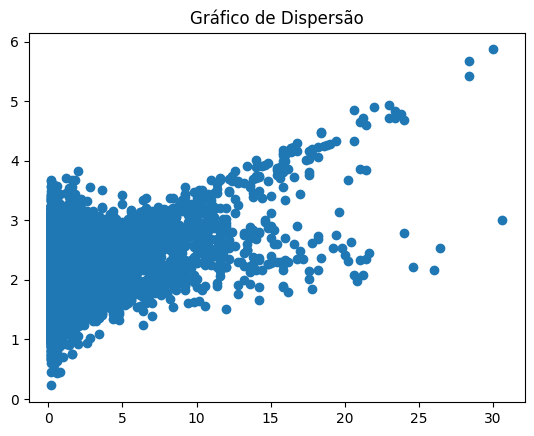

In [133]:
x = y_test
y = final_pred

plt.title('Gráfico de Dispersão')
plt.scatter(x, y)
plt.show()

### Observações finais